# Vysca Rina LF
# 5220411025
## Perbandingan Tingkat Kepuasan Pengguna Aplikasi Streaming Terpopuler (Netflix vs Vidio)

# SCRAPING

In [1]:
!pip install google_play_scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.7 MB/s eta 0:00:00


In [ ]:
from google_play_scraper import reviews, Sort
import pandas as pd

def get_reviews(app_id, app_name, count=3000):
    result, _ = reviews(
        app_id,
        lang='id',
        country='id',
        sort=Sort.NEWEST,
        count=count
    )

    data = []
    for r in result:
        data.append({
            'review': r['content'],
            'rating': r['score'],
            'app': app_name
        })

    return pd.DataFrame(data)

netflix_id = "com.netflix.mediaclient"
vidio_id   = "com.vidio.android"

df_netflix = get_reviews(netflix_id, "Netflix", 3000)
df_vidio   = get_reviews(vidio_id, "Vidio", 3000)

df_netflix.to_csv("scraping_netflix.csv", index=False)
df_vidio.to_csv("scraping_vidio.csv", index=False)

print("Netflix:", df_netflix.shape)
print("Vidio  :", df_vidio.shape)
print("\nContoh Netflix:")
print(df_netflix.head())
print("\nContoh Vidio:")
print(df_vidio.head())


Netflix: (3000, 3)
Vidio  : (3000, 3)

Contoh Netflix:
                                              review  rating      app
0  perkara ganti akun aja di hp gabisa bisa terus...       1  Netflix
1  aplikasi yang sangat buruk dan ribet, mau masu...       1  Netflix
2            suka bug buffering gk berhenti berhenti       1  Netflix
3  Udah daftar sesuai aturan eh malah gagal terus...       1  Netflix
4                                                 ok       4  Netflix

Contoh Vidio:
                                              review  rating    app
0  aplikasi yg sudah lama saya gunakan tapi masih...       1  Vidio
1                       saya suka sama apk video ini       5  Vidio
2                                       banyak iklan       1  Vidio
3                                             mantap       5  Vidio
4                                    Sangat membantu       5  Vidio


In [7]:
import os
import pandas as pd
from google_play_scraper import reviews, Sort

def get_reviews(app_id, app_name, count=3000):
    result, _ = reviews(
        app_id,
        lang='id',
        country='id',
        sort=Sort.NEWEST,
        count=count
    )

    data = []
    for r in result:
        data.append({
            'review': r['content'],
            'rating': r['score'],
            'app': app_name
        })

    return pd.DataFrame(data)

netflix_file = "scraping_netflix.csv"
vidio_file   = "scraping_vidio.csv"

netflix_id = "com.netflix.mediaclient"
vidio_id   = "com.vidio.android"

# Netflix
if os.path.exists(netflix_file):
    print("Data Netflix diambil dari file (TIDAK scraping ulang)")
    df_netflix = pd.read_csv(netflix_file)
else:
    print("Scraping Netflix dilakukan (1x)")
    df_netflix = get_reviews(netflix_id, "Netflix", 3000)
    df_netflix.to_csv(netflix_file, index=False)

# Vidio
if os.path.exists(vidio_file):
    print("Data Vidio diambil dari file (TIDAK scraping ulang)")
    df_vidio = pd.read_csv(vidio_file)
else:
    print("Scraping Vidio dilakukan (1x)")
    df_vidio = get_reviews(vidio_id, "Vidio", 3000)
    df_vidio.to_csv(vidio_file, index=False)

print("Netflix:", df_netflix.shape)
print("Vidio  :", df_vidio.shape)


Data Netflix diambil dari file (TIDAK scraping ulang)
Data Vidio diambil dari file (TIDAK scraping ulang)
Netflix: (3000, 3)
Vidio  : (3000, 3)


# LIBRARY

In [8]:
!pip install Sastrawi

In [9]:
!pip install pandas nltk Sastrawi wordcloud matplotlib emoji

In [10]:
import pandas as pd
import re
import string
import nltk
import emoji
import matplotlib.pyplot as plt

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# NETFLIX

### CASE FOLDING & CLEANING

In [11]:
# kamus normalisasi kata gaul / typo (hasil observasi review aplikasi streaming)
normalisasi_dict = {
    # negasi
    "gk": "tidak",
    "ga": "tidak",
    "nggak": "tidak",
    "tdk": "tidak",
    "tak": "tidak",
    "kagak":"tidak",
    "gak": "tidak",

    # intensitas
    "bgt": "banget",
    "bgtt": "banget",
    "bangettt": "banget",

    # kata penghubung
    "dr": "dari",
    "dgn": "dengan",
    "krn": "karena",
    "tp": "tapi",
    "trs": "terus",

    # kata kerja
    "udh": "sudah",
    "sdh": "sudah",
    "blm": "belum",
    "bisaaa": "bisa",
    "gabisa": "tidak bisa",
    "tmbhin":"tambah",

    # kata ganti & keterangan
    "aja": "saja",
    "sm": "sama",
    "yg": "yang",
    "lg": "lagi",
    "jd": "jadi",
    "pdhl": "padahal",

    # istilah aplikasi
    "apk": "aplikasi",
    "apknya": "aplikasi",
    "apps": "aplikasi",
    "netplik": "netflix",

    # kualitas & performa
    "bgus": "bagus",
    "baguuus": "bagus",
    "jelekknya": "jelek",
    "lemot": "lambat",
    "lemottt": "lambat",
    "errorrr": "error",
    "ngelag": "lag",
    "lagg": "lag",

    # teknis streaming
    "loadingnya": "loading",
    "ngeload": "loading",
    "buffering": "buffer",
    "buffernya": "buffer",
    "hdnya": "hd",

    # penilaian
    "mantappp": "mantap",
    "kereenn": "keren",
    "parahhh": "parah",
    "recommended": "direkomendasikan",
    "okay":"oke"
}

def normalize_slang(text):
    words = text.split()
    return ' '.join([normalisasi_dict.get(word, word) for word in words])

def remove_double_char(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

def cleaning(text):
    text = str(text).lower()                              # case folding
    text = re.sub(r'http\S+|www\S+', '', text)            # hapus URL
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)            # hapus NON ASCII
    text = remove_double_char(text)                       # huruf berulang
    text = normalize_slang(text)                          # normalisasi gaul
    text = re.sub(r'[^\w\s]', ' ', text)                  # hapus tanda baca
    text = re.sub(r'\d+', ' ', text)                      # hapus angka
    text = re.sub(r'\s+', ' ', text).strip()              # rapikan spasi
    text = ' '.join([word for word in text.split() if len(word) > 3]) # hapus kata <= 3 huruf
    return text

df_netflix['clean_review'] = df_netflix['review'].fillna('').apply(cleaning)

print(df_netflix[['review', 'clean_review']].head())

df_netflix.to_excel(
    "hasil_cleaning_netflix.xlsx",
    index=False
)
print("File Excel berhasil dibuat: hasil_cleaning_netflix.xlsx")

                                              review  \
0  perkara ganti akun aja di hp gabisa bisa terus...   
1  aplikasi yang sangat buruk dan ribet, mau masu...   
2            suka bug buffering gk berhenti berhenti   
3  Udah daftar sesuai aturan eh malah gagal terus...   
4                                                 ok   

                                        clean_review  
0  perkara ganti akun saja tidak bisa bisa terus ...  
1  aplikasi yang sangat buruk ribet masuk saja ri...  
2                suka buffer tidak berhenti berhenti  
3  udah daftar sesuai aturan malah gagal terus ka...  
4                                                     
File Excel berhasil dibuat: hasil_cleaning_netflix.xlsx


### STOPWORD

In [12]:
# inisialisasi stopword bahasa Indonesia
factory = StopWordRemoverFactory()
stopword = set(factory.get_stop_words())

df_netflix['stopword_removed'] = df_netflix['clean_review'].apply(
    lambda x: ' '.join([w for w in x.split() if w not in stopword])
)

print(df_netflix[['clean_review', 'stopword_removed']].head())
df_netflix.to_excel(
    "hasil_stopword_netflix.xlsx",
    index=False
)
print("File Excel berhasil dibuat: hasil_stopword_netflix.xlsx")

                                        clean_review  \
0  perkara ganti akun saja tidak bisa bisa terus ...   
1  aplikasi yang sangat buruk ribet masuk saja ri...   
2                suka buffer tidak berhenti berhenti   
3  udah daftar sesuai aturan malah gagal terus ka...   
4                                                      

                                    stopword_removed  
0  perkara ganti akun terus masuk udah uninstall ...  
1     aplikasi sangat buruk ribet masuk ribet banget  
2                      suka buffer berhenti berhenti  
3  udah daftar sesuai aturan malah gagal terus ka...  
4                                                     
File Excel berhasil dibuat: hasil_stopword_netflix.xlsx


### STEMMING

In [13]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# inisialisasi stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

df_netflix['stemming'] = df_netflix['stopword_removed'].apply(
    lambda x: ' '.join([stemmer.stem(word) for word in x.split()])
)

print(df_netflix[['clean_review', 'stopword_removed', 'stemming']].head())

df_netflix.to_excel(
    "hasil_stemming_netflix.xlsx",
    index=False
)
print("File Excel berhasil dibuat: hasil_stemming_netflix.xlsx")

                                        clean_review  \
0  perkara ganti akun saja tidak bisa bisa terus ...   
1  aplikasi yang sangat buruk ribet masuk saja ri...   
2                suka buffer tidak berhenti berhenti   
3  udah daftar sesuai aturan malah gagal terus ka...   
4                                                      

                                    stopword_removed  \
0  perkara ganti akun terus masuk udah uninstall ...   
1     aplikasi sangat buruk ribet masuk ribet banget   
2                      suka buffer berhenti berhenti   
3  udah daftar sesuai aturan malah gagal terus ka...   
4                                                      

                                            stemming  
0  perkara ganti akun terus masuk udah uninstall ...  
1     aplikasi sangat buruk ribet masuk ribet banget  
2                            suka buffer henti henti  
3  udah daftar sesuai atur malah gagal terus kart...  
4                                                  

### LABELING

In [14]:
def star_label(rating):
    if rating <= 2:
        return 'Negatif'
    elif rating == 3:
        return 'Netral'
    else:
        return 'Positif'

df_netflix['sentimen_awal'] = df_netflix['rating'].apply(star_label)

df_netflix[['rating', 'sentimen_awal']].head()

,rating,sentimen_awal
0,1,Negatif
1,1,Negatif
2,1,Negatif
3,1,Negatif
4,4,Positif


### VALIDASI LABELING (LEXICON BASED)

In [15]:
from IPython.display import display

positif = [
    'bagus','mantap','cepat','mudah','puas','keren',
    'stabil','jernih','oke','baik','lancar',
    'mantul','recommended','nyaman','suka', 'best'
]

negatif = [
    'jelek','buruk','lemot','error','mahal','kecewa',
    'parah','lag','rusak','lambat','susah','ribet',
    'gagal','henti','berhenti','buffer','loading',
    'uninstall','masalah','payah','ganggu','sulit', 'burik'
]

negasi = ['tidak','kurang','gak','nggak','belum']

# Fungsi lexicon
def lexicon_sentiment(text):
    if not isinstance(text, str):
        return 'Netral'

    words = text.lower().split()
    score = 0

    for i, w in enumerate(words):

        # cek positif / negatif
        if w in positif:
            score += 1
        elif w in negatif:
            score -= 1

        # negasi sederhana
        if w in negasi and i + 1 < len(words):
            if words[i + 1] in positif:
                score -= 1
            elif words[i + 1] in negatif:
                score += 1

    # aturan keputusan
    if score >= 1:
        return 'Positif'
    elif score <= -1:
        return 'Negatif'
    else:
        return 'Netral'

df_netflix['sentimen_lexicon'] = df_netflix['stemming'].apply(lexicon_sentiment)

# Validasi data
df_valid = df_netflix[
    (df_netflix['sentimen_awal'] == df_netflix['sentimen_lexicon']) |
    (df_netflix['sentimen_lexicon'] == 'Netral')
].copy()

print("Total data awal :", len(df_netflix))
print("Data valid      :", len(df_valid))
print("Data dihapus    :", len(df_netflix) - len(df_valid))

output_file = "hasil_sentimen_valid_netflix.xlsx"

df_valid.to_excel(
    output_file,
    index=False,
    sheet_name="Data_Valid_Sentimen"
)

display(
    df_netflix[['rating','sentimen_awal','sentimen_lexicon','stemming']].head(10)
)

print(f"Data berhasil disimpan ke file: {output_file}")


Total data awal : 3000
Data valid      : 2727
Data dihapus    : 273


,rating,sentimen_awal,sentimen_lexicon,stemming
0,1,Negatif,Negatif,perkara ganti akun terus masuk udah uninstall ...
1,1,Negatif,Negatif,aplikasi sangat buruk ribet masuk ribet banget
2,1,Negatif,Negatif,suka buffer henti henti
3,1,Negatif,Negatif,udah daftar sesuai atur malah gagal terus kart...
4,4,Positif,Netral,
5,1,Negatif,Negatif,masuk susah suruh bayar trus maksa
6,1,Negatif,Negatif,aplikasi banyak drama login susah house hold b...
7,3,Netral,Positif,bintang dulu bagus tambah
8,1,Negatif,Netral,apa bayar dulu aplikasi jelas
9,5,Positif,Netral,


Data berhasil disimpan ke file: hasil_sentimen_valid_netflix.xlsx


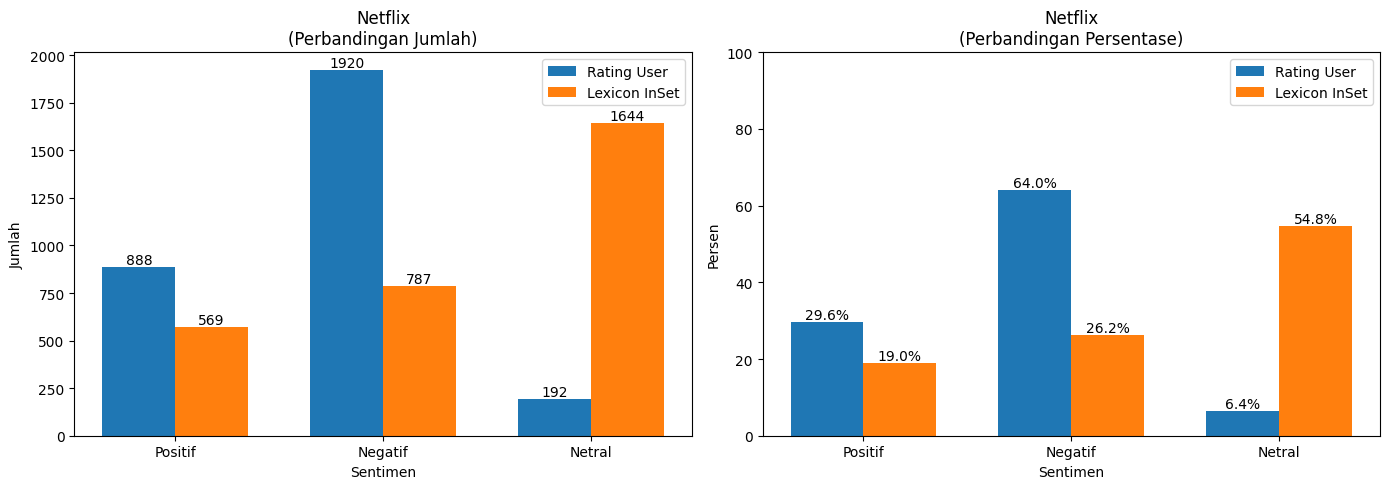

In [16]:
# Visualisasi
import matplotlib.pyplot as plt
import numpy as np

sentimen_labels = ['Positif', 'Negatif', 'Netral']

# Hitung jumlah
rating_counts = df_netflix['sentimen_awal'].value_counts().reindex(sentimen_labels, fill_value=0)
lexicon_counts = df_netflix['sentimen_lexicon'].value_counts().reindex(sentimen_labels, fill_value=0)

# Hitung persentase
rating_percent = rating_counts / rating_counts.sum() * 100
lexicon_percent = lexicon_counts / lexicon_counts.sum() * 100

x = np.arange(len(sentimen_labels))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Perbandingan jumlah
bars1 = axes[0].bar(x - width/2, rating_counts, width, label='Rating User')
bars2 = axes[0].bar(x + width/2, lexicon_counts, width, label='Lexicon InSet')

axes[0].set_title('Netflix\n(Perbandingan Jumlah)')
axes[0].set_xlabel('Sentimen')
axes[0].set_ylabel('Jumlah')
axes[0].set_xticks(x)
axes[0].set_xticklabels(sentimen_labels)
axes[0].legend()

for bar in bars1:
    axes[0].text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center', va='bottom'
    )

for bar in bars2:
    axes[0].text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center', va='bottom'
    )

# Perbandingan persentase
bars3 = axes[1].bar(x - width/2, rating_percent, width, label='Rating User')
bars4 = axes[1].bar(x + width/2, lexicon_percent, width, label='Lexicon InSet')

axes[1].set_title('Netflix\n(Perbandingan Persentase)')
axes[1].set_xlabel('Sentimen')
axes[1].set_ylabel('Persen')
axes[1].set_xticks(x)
axes[1].set_xticklabels(sentimen_labels)
axes[1].set_ylim(0, 100)
axes[1].legend()

for bar in bars3:
    axes[1].text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{bar.get_height():.1f}%",
        ha='center', va='bottom'
    )

for bar in bars4:
    axes[1].text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{bar.get_height():.1f}%",
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()

### WORDCLOUD MASING- MASING SENTIMEN

In [17]:
from wordcloud import WordCloud

def plot_wordcloud(df, text_col, title):
    text = ' '.join(df[text_col].dropna())
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

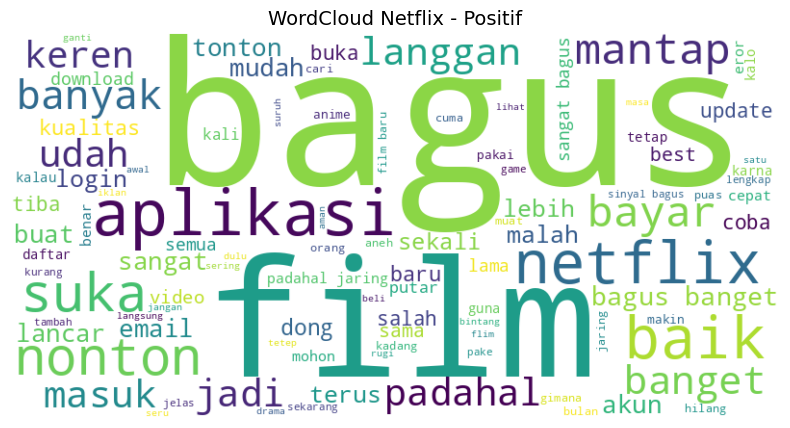

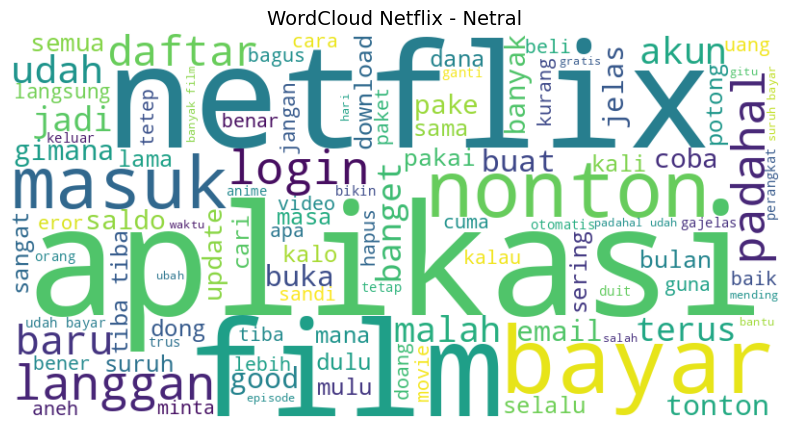

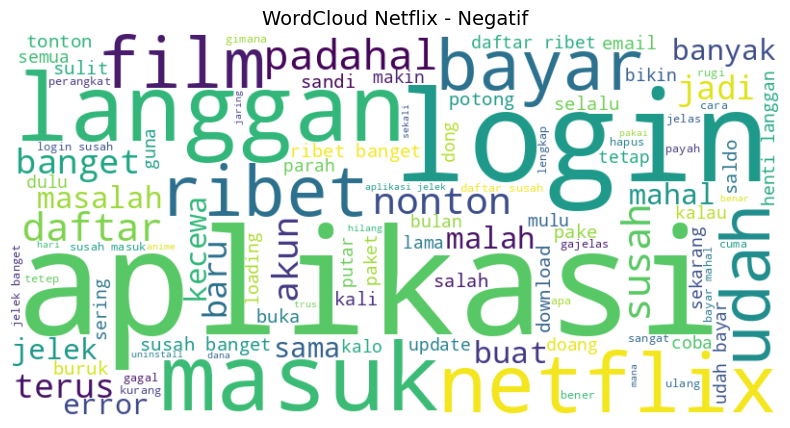

In [45]:
plot_wordcloud(
    df_netflix[df_netflix['sentimen_lexicon']=='Positif'],
    'stemming',
    'WordCloud Netflix - Positif'
)

plot_wordcloud(
    df_netflix[df_netflix['sentimen_lexicon']=='Netral'],
    'stemming',
    'WordCloud Netflix - Netral'
)

plot_wordcloud(
    df_netflix[df_netflix['sentimen_lexicon']=='Negatif'],
    'stemming',
    'WordCloud Netflix - Negatif'
)


### BIGRAM MASING-MASING SENTIMEN

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

def generate_bigram_tokens(text):
    if pd.isna(text):
        return []
    words = text.split()
    return [' '.join(words[i:i+2]) for i in range(len(words)-1)]

df_netflix['bigram_tokens'] = df_netflix['stemming'].apply(generate_bigram_tokens)

df_netflix['bigram_text'] = df_netflix['bigram_tokens'].apply(lambda x: ', '.join(x))

df_netflix.to_excel(
    "hasil_bigram_netflix.xlsx",
    index=False
)

print(" File Excel berhasil disimpan: hasil_bigram_netflix.xlsx")

 File Excel berhasil disimpan: hasil_bigram_netflix.xlsx


In [20]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_ngram_bar(df, text_col, ngram_range, title, color):
    vec = CountVectorizer(ngram_range=ngram_range)
    X = vec.fit_transform(df[text_col].dropna())

    freqs = pd.DataFrame({
        'ngram': vec.get_feature_names_out(),
        'freq': X.sum(axis=0).A1
    }).sort_values(by='freq', ascending=False).head(10)

    plt.figure(figsize=(8,5))
    plt.barh(
        freqs['ngram'],
        freqs['freq'],
        color=color,
        edgecolor='black'
    )
    plt.gca().invert_yaxis()
    plt.title(title, fontsize=12)
    plt.xlabel("Frekuensi")
    plt.ylabel("Frasa / Kata")
    plt.tight_layout()
    plt.show()

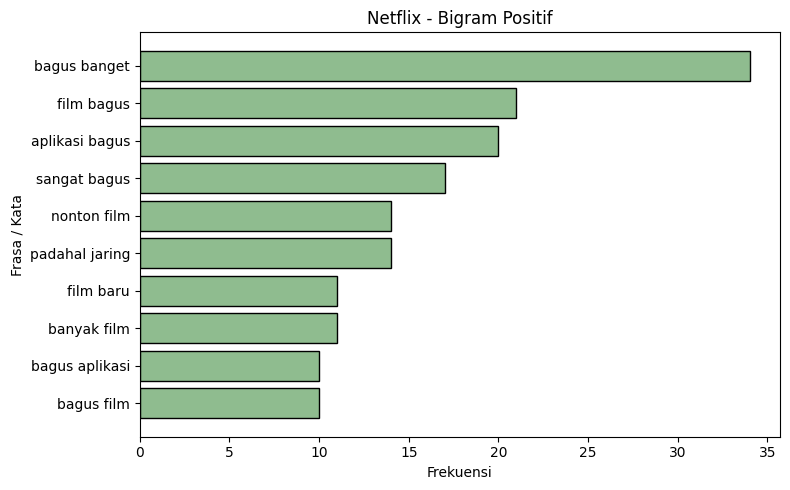

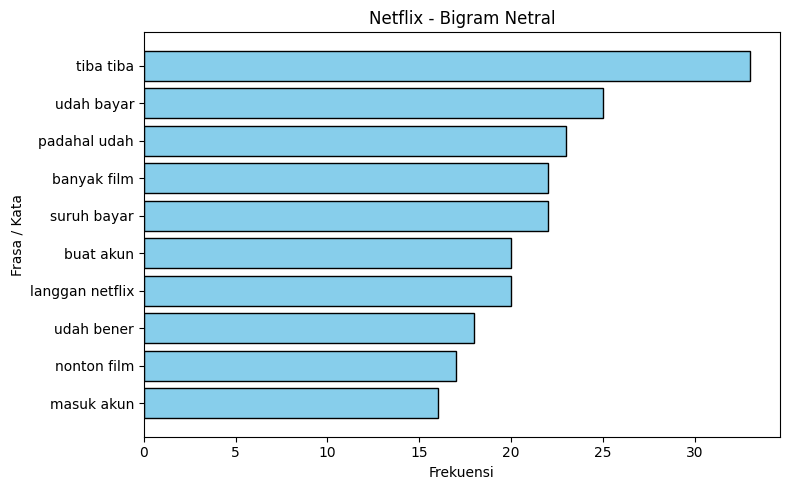

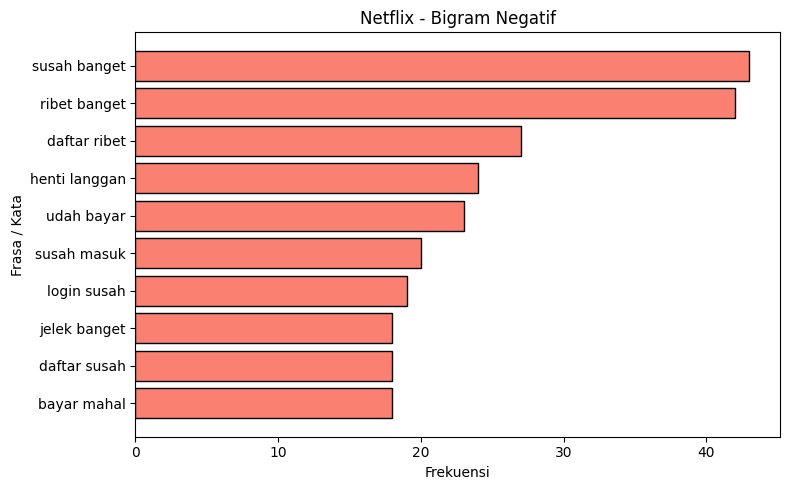

In [21]:
plot_ngram_bar(
    df_netflix[df_netflix['sentimen_lexicon']=='Positif'],
    'stemming',
    (2,2),
    'Netflix - Bigram Positif',
    'darkseagreen'
)

plot_ngram_bar(
    df_netflix[df_netflix['sentimen_lexicon']=='Netral'],
    'stemming',
    (2,2),
    'Netflix - Bigram Netral',
    'skyblue'
)

plot_ngram_bar(
    df_netflix[df_netflix['sentimen_lexicon']=='Negatif'],
    'stemming',
    (2,2),
    'Netflix - Bigram Negatif',
    'salmon'
)

### TRIGRAM MASING-MASING SENTIMEN

In [29]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

def generate_trigram_tokens(text):
    if pd.isna(text):
        return []
    words = text.split()
    return [' '.join(words[i:i+3]) for i in range(len(words)-2)]

df_netflix['trigram_tokens'] = df_netflix['stemming'].apply(generate_trigram_tokens)

df_netflix['trigram_text'] = df_netflix['trigram_tokens'].apply(lambda x: ', '.join(x))

df_netflix.to_excel(
    "hasil_trigram_netflix.xlsx",
    index=False
)

print(" File Excel berhasil disimpan: hasil_trigram_netflix.xlsx")

 File Excel berhasil disimpan: hasil_trigram_netflix.xlsx


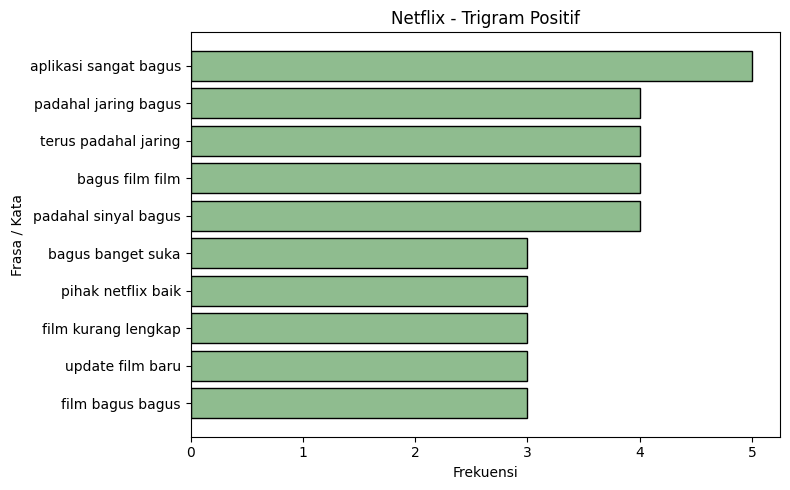

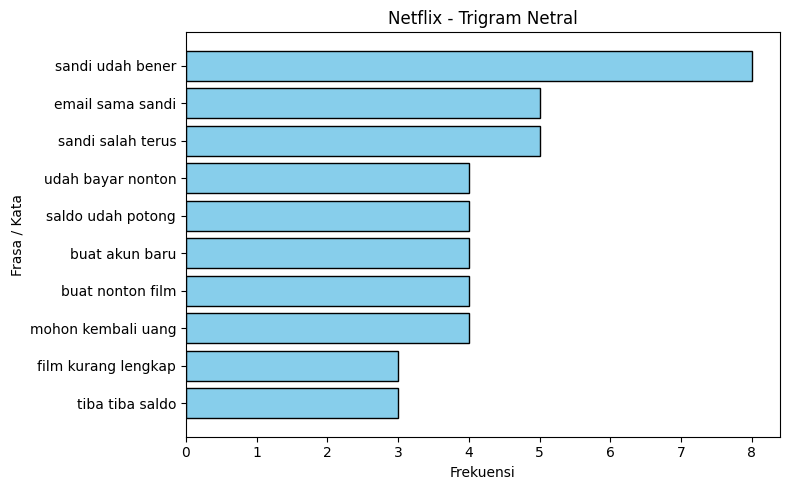

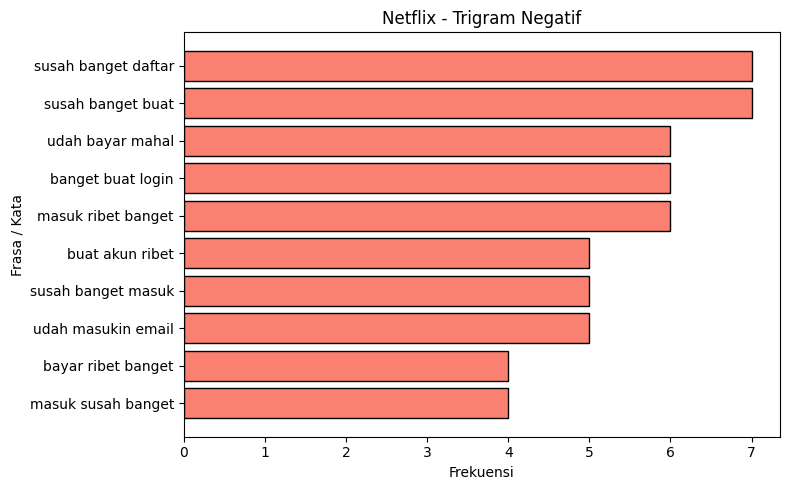

In [40]:
plot_ngram_bar(
    df_netflix[df_netflix['sentimen_lexicon']=='Positif'],
    'stemming',
    (3,3),
    'Netflix - Trigram Positif',
    'darkseagreen'
)

plot_ngram_bar(
    df_netflix[df_netflix['sentimen_lexicon']=='Netral'],
    'stemming',
    (3,3),
    'Netflix - Trigram Netral',
    'skyblue'
)

plot_ngram_bar(
    df_netflix[df_netflix['sentimen_lexicon']=='Negatif'],
    'stemming',
    (3,3),
    'Netflix - Trigram Negatif',
    'salmon'
)

# VIDIO

### CASE FOLDING & CLEANING

In [31]:
# kamus normalisasi kata gaul / typo (hasil observasi review aplikasi streaming)
normalisasi_dict = {
    # negasi
    "gk": "tidak",
    "ga": "tidak",
    "nggak": "tidak",
    "tdk": "tidak",
    "tak": "tidak",
    "kagak":"tidak",
    "gak": "tidak",

    # intensitas
    "bgt": "banget",
    "bgtt": "banget",
    "bangettt": "banget",

    # kata penghubung
    "dr": "dari",
    "dgn": "dengan",
    "krn": "karena",
    "tp": "tapi",
    "trs": "terus",

    # kata kerja
    "udh": "sudah",
    "sdh": "sudah",
    "blm": "belum",
    "bisaaa": "bisa",
    "gabisa": "tidak bisa",

    # kata ganti & keterangan
    "aja": "saja",
    "sm": "sama",
    "yg": "yang",
    "lg": "lagi",
    "jd": "jadi",
    "pdhl": "padahal",

    # istilah aplikasi
    "apk": "aplikasi",
    "apknya": "aplikasi",
    "apps": "aplikasi",
    "netplik": "netflix",

    # kualitas & performa
    "bgus": "bagus",
    "baguuus": "bagus",
    "jelekknya": "jelek",
    "lemot": "lambat",
    "lemottt": "lambat",
    "errorrr": "error",
    "ngelag": "lag",
    "lagg": "lag",

    # teknis streaming
    "loadingnya": "loading",
    "ngeload": "loading",
    "buffering": "buffer",
    "buffernya": "buffer",
    "hdnya": "hd",

    # penilaian
    "mantappp": "mantap",
    "kereenn": "keren",
    "parahhh": "parah",
    "recommended": "direkomendasikan",
    "okay":"oke"
}

def normalize_slang(text):
    words = text.split()
    return ' '.join([normalisasi_dict.get(word, word) for word in words])

def remove_double_char(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

def cleaning(text):
    text = str(text).lower()                              # case folding
    text = re.sub(r'http\S+|www\S+', '', text)            # hapus URL
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)            # hapus NON ASCII
    text = remove_double_char(text)                       # huruf berulang
    text = normalize_slang(text)                          # normalisasi gaul
    text = re.sub(r'[^\w\s]', ' ', text)                  # hapus tanda baca
    text = re.sub(r'\d+', ' ', text)                      # hapus angka
    text = re.sub(r'\s+', ' ', text).strip()              # rapikan spasi
    text = ' '.join([word for word in text.split() if len(word) > 3]) # hapus kata <= 3 huruf
    return text

df_vidio['clean_review2'] = df_vidio['review'].fillna('').apply(cleaning)

print(df_vidio[['review', 'clean_review2']].head())

df_vidio.to_excel(
    "hasil_cleaning_vidio.xlsx",
    index=False
)
print("File Excel berhasil dibuat: hasil_cleaning_vidio.xlsx")

                                              review  \
0  aplikasi yg sudah lama saya gunakan tapi masih...   
1                       saya suka sama apk video ini   
2                                       banyak iklan   
3                                             mantap   
4                                    Sangat membantu   

                                       clean_review2  
0  aplikasi yang sudah lama saya gunakan tapi mas...  
1                      saya suka sama aplikasi video  
2                                       banyak iklan  
3                                             mantap  
4                                    sangat membantu  
File Excel berhasil dibuat: hasil_cleaning_vidio.xlsx


### STOPWORD

In [32]:
# inisialisasi stopword bahasa Indonesia
factory = StopWordRemoverFactory()
stopword = set(factory.get_stop_words())

df_vidio['stopword_removed2'] = df_vidio['clean_review2'].apply(
    lambda x: ' '.join([w for w in x.split() if w not in stopword])
)

print(df_vidio[['clean_review2', 'stopword_removed2']].head())
df_vidio.to_excel(
    "hasil_stopword_vidio.xlsx",
    index=False
)
print("File Excel berhasil dibuat: hasil_stopword_vidio.xlsx")


                                       clean_review2  \
0  aplikasi yang sudah lama saya gunakan tapi mas...   
1                      saya suka sama aplikasi video   
2                                       banyak iklan   
3                                             mantap   
4                                    sangat membantu   

                                   stopword_removed2  
0  aplikasi lama gunakan terus membuat kecewa pen...  
1                           suka sama aplikasi video  
2                                       banyak iklan  
3                                             mantap  
4                                    sangat membantu  
File Excel berhasil dibuat: hasil_stopword_vidio.xlsx


### STEMMING

In [33]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# inisialisasi stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

df_vidio['stemming2'] = df_vidio['stopword_removed2'].apply(
    lambda x: ' '.join([stemmer.stem(word) for word in x.split()])
)

print(df_vidio[['clean_review2', 'stopword_removed2', 'stemming2']].head())

df_vidio.to_excel(
    "hasil_stemming_vidio.xlsx",
    index=False
)
print("File Excel berhasil dibuat: hasil_stemming_vidio.xlsx")

                                       clean_review2  \
0  aplikasi yang sudah lama saya gunakan tapi mas...   
1                      saya suka sama aplikasi video   
2                                       banyak iklan   
3                                             mantap   
4                                    sangat membantu   

                                   stopword_removed2  \
0  aplikasi lama gunakan terus membuat kecewa pen...   
1                           suka sama aplikasi video   
2                                       banyak iklan   
3                                             mantap   
4                                    sangat membantu   

                                           stemming2  
0  aplikasi lama guna terus buat kecewa curi puls...  
1                           suka sama aplikasi video  
2                                       banyak iklan  
3                                             mantap  
4                                       sangat bant

### LABELING

In [34]:
def star_label2(rating):
    if rating <= 2:
        return 'Negatif'
    elif rating == 3:
        return 'Netral'
    else:
        return 'Positif'

df_vidio['sentimen_awal2'] = df_vidio['rating'].apply(star_label2)

df_vidio[['rating', 'sentimen_awal2']].head()

,rating,sentimen_awal2
0,1,Negatif
1,5,Positif
2,1,Negatif
3,5,Positif
4,5,Positif


### VALIDASI LABEL (LEXICON BASED)

In [35]:
from IPython.display import display

positif = [
    'bagus','mantap','cepat','mudah','puas','keren',
    'stabil','jernih','oke','baik','lancar',
    'mantul','recommended','nyaman','suka', 'best'
]

negatif = [
    'jelek','buruk','lemot','error','mahal','kecewa',
    'parah','lag','rusak','lambat','susah','ribet',
    'gagal','henti','berhenti','buffer','loading',
    'uninstall','masalah','payah','ganggu','sulit', 'burik'
]

negasi = ['tidak','kurang','gak','nggak','belum']


# Fungsi lexicon
def lexicon_sentiment2(text):
    if not isinstance(text, str):
        return 'Netral'

    words = text.lower().split()
    score = 0

    for i, w in enumerate(words):

        # cek positif / negatif
        if w in positif:
            score += 1
        elif w in negatif:
            score -= 1

        # negasi sederhana
        if w in negasi and i + 1 < len(words):
            if words[i + 1] in positif:
                score -= 1
            elif words[i + 1] in negatif:
                score += 1

    # aturan keputusan
    if score >= 1:
        return 'Positif'
    elif score <= -1:
        return 'Negatif'
    else:
        return 'Netral'

df_vidio['sentimen_lexicon2'] = df_vidio['stemming2'].apply(lexicon_sentiment2)

# Validasi data
df_valid = df_vidio[
    (df_vidio['sentimen_awal2'] == df_vidio['sentimen_lexicon2']) |
    (df_vidio['sentimen_lexicon2'] == 'Netral')
].copy()

print("Total data awal :", len(df_vidio))
print("Data valid      :", len(df_valid))
print("Data dihapus    :", len(df_vidio) - len(df_valid))

output_file = "hasil_sentimen_valid_vidio.xlsx"

df_valid.to_excel(
    output_file,
    index=False,
    sheet_name="Data_Valid_Sentimen2"
)

display(
    df_vidio[['rating','sentimen_awal2','sentimen_lexicon2','stemming2']].head(10)
)

print(f"Data berhasil disimpan ke file: {output_file}")


Total data awal : 3000
Data valid      : 2740
Data dihapus    : 260


,rating,sentimen_awal2,sentimen_lexicon2,stemming2
0,1,Negatif,Negatif,aplikasi lama guna terus buat kecewa curi puls...
1,5,Positif,Positif,suka sama aplikasi video
2,1,Negatif,Netral,banyak iklan
3,5,Positif,Positif,mantap
4,5,Positif,Netral,sangat bantu
5,3,Netral,Netral,begimana cerita udah potong saldo langgan pake...
6,1,Negatif,Netral,hilang uang otomatis dana karna bayar otomatis...
7,1,Negatif,Netral,heran langgan iklan
8,1,Negatif,Netral,saldo dana potong padahal laku transaksi apa
9,1,Negatif,Negatif,begini kualitas stasion indonesia langgan buat...


Data berhasil disimpan ke file: hasil_sentimen_valid_vidio.xlsx


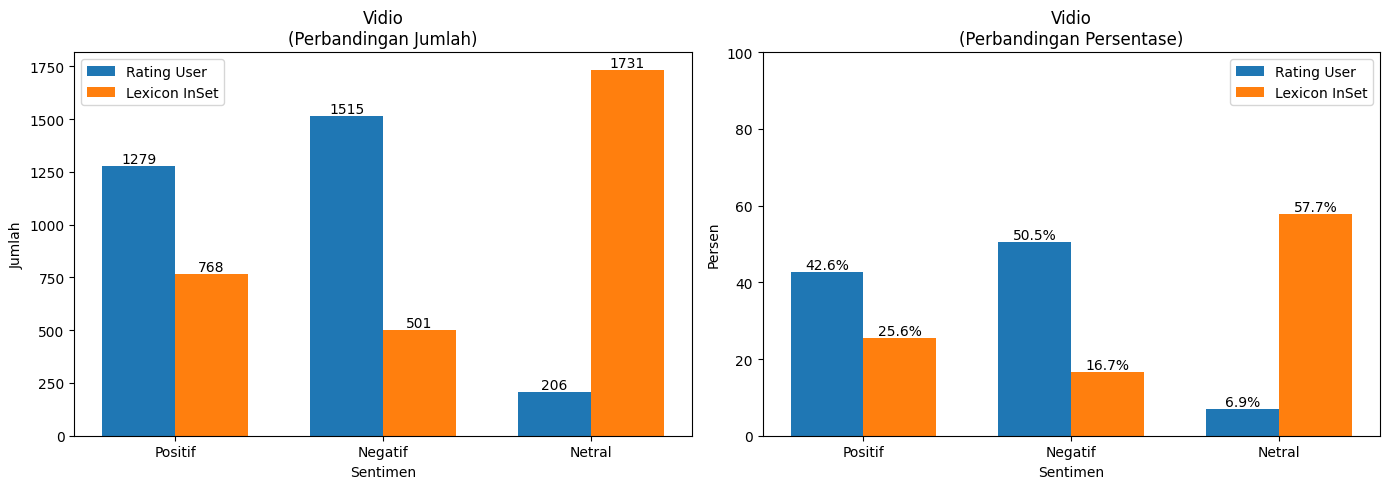

In [36]:
# Visualisasi
import matplotlib.pyplot as plt
import numpy as np

sentimen_labels = ['Positif', 'Negatif', 'Netral']

# Hitung jumlah
rating_counts = df_vidio['sentimen_awal2'].value_counts().reindex(sentimen_labels, fill_value=0)
lexicon_counts = df_vidio['sentimen_lexicon2'].value_counts().reindex(sentimen_labels, fill_value=0)

# Hitung persentase
rating_percent = rating_counts / rating_counts.sum() * 100
lexicon_percent = lexicon_counts / lexicon_counts.sum() * 100

x = np.arange(len(sentimen_labels))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Perbandingan jumlah
bars1 = axes[0].bar(x - width/2, rating_counts, width, label='Rating User')
bars2 = axes[0].bar(x + width/2, lexicon_counts, width, label='Lexicon InSet')

axes[0].set_title('Vidio\n(Perbandingan Jumlah)')
axes[0].set_xlabel('Sentimen')
axes[0].set_ylabel('Jumlah')
axes[0].set_xticks(x)
axes[0].set_xticklabels(sentimen_labels)
axes[0].legend()

for bar in bars1:
    axes[0].text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center', va='bottom'
    )

for bar in bars2:
    axes[0].text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center', va='bottom'
    )

# Perbandingan persentase
bars3 = axes[1].bar(x - width/2, rating_percent, width, label='Rating User')
bars4 = axes[1].bar(x + width/2, lexicon_percent, width, label='Lexicon InSet')

axes[1].set_title('Vidio\n(Perbandingan Persentase)')
axes[1].set_xlabel('Sentimen')
axes[1].set_ylabel('Persen')
axes[1].set_xticks(x)
axes[1].set_xticklabels(sentimen_labels)
axes[1].set_ylim(0, 100)
axes[1].legend()

for bar in bars3:
    axes[1].text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{bar.get_height():.1f}%",
        ha='center', va='bottom'
    )

for bar in bars4:
    axes[1].text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{bar.get_height():.1f}%",
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()

### WORDCLOUD MASING-MASING SENTIMEN

In [37]:
from wordcloud import WordCloud

def plot_wordcloud(df, text_col, title):
    text = ' '.join(df[text_col].dropna())
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

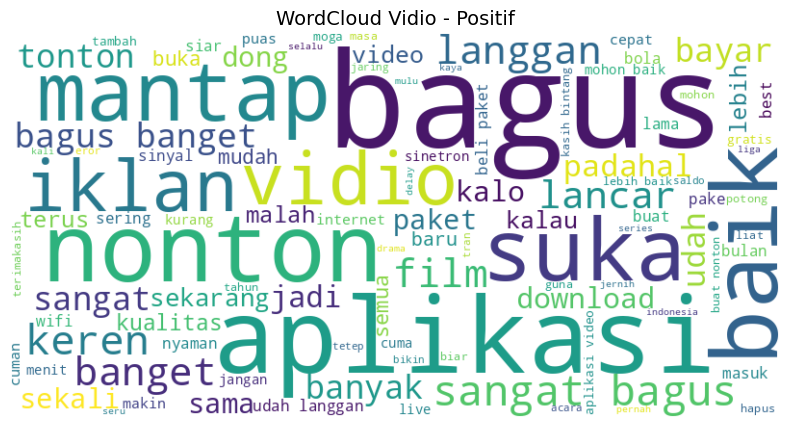

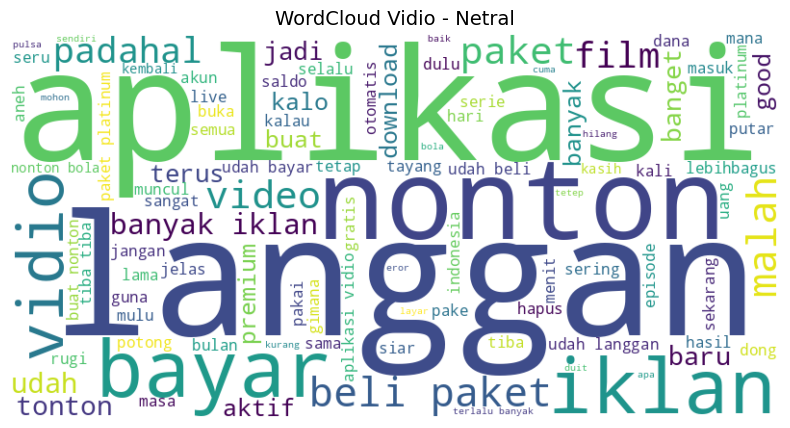

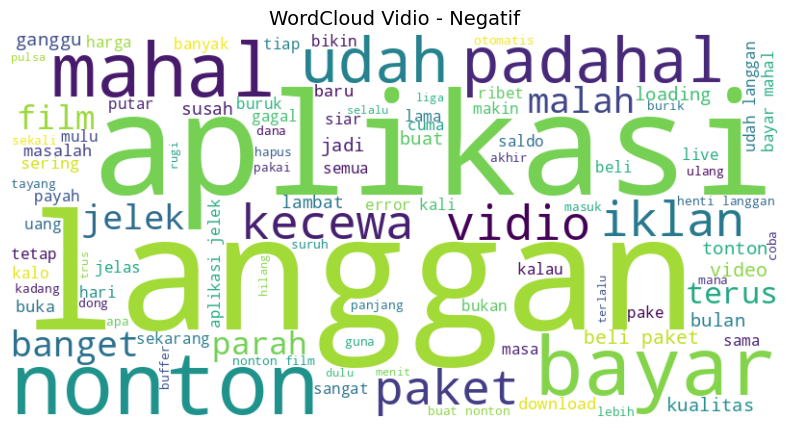

In [43]:
plot_wordcloud(
    df_vidio[df_vidio['sentimen_lexicon2']=='Positif'],
    'stemming2',
    'WordCloud Vidio - Positif'
)

plot_wordcloud(
    df_vidio[df_vidio['sentimen_lexicon2']=='Netral'],
    'stemming2',
    'WordCloud Vidio - Netral'
)

plot_wordcloud(
    df_vidio[df_vidio['sentimen_lexicon2']=='Negatif'],
    'stemming2',
    'WordCloud Vidio - Negatif'
)


### BIGRAM MASING-MASING SENTIMEN

In [46]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

def generate_bigram_tokens2(text):
    if pd.isna(text):
        return []
    words = text.split()
    return [' '.join(words[i:i+2]) for i in range(len(words)-1)]

df_vidio['bigram_tokens2'] = df_vidio['stemming2'].apply(generate_bigram_tokens2)

df_vidio['bigram_text2'] = df_vidio['bigram_tokens2'].apply(lambda x: ', '.join(x))

df_vidio.to_excel(
    "hasil_bigram_vidio.xlsx",
    index=False
)

print(" File Excel berhasil disimpan: hasil_bigram_vidio.xlsx")

 File Excel berhasil disimpan: hasil_bigram_vidio.xlsx


In [47]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd

def plot_ngram_bar(df, text_col, ngram_range, title, color):
    vec = CountVectorizer(ngram_range=ngram_range)
    X = vec.fit_transform(df[text_col].dropna())

    freqs = pd.DataFrame({
        'ngram': vec.get_feature_names_out(),
        'freq': X.sum(axis=0).A1
    }).sort_values(by='freq', ascending=False).head(10)

    plt.figure(figsize=(8,5))
    plt.barh(
        freqs['ngram'],
        freqs['freq'],
        color=color,
        edgecolor='black'
    )
    plt.gca().invert_yaxis()
    plt.title(title, fontsize=12)
    plt.xlabel("Frekuensi")
    plt.ylabel("Frasa / Kata")
    plt.tight_layout()
    plt.show()


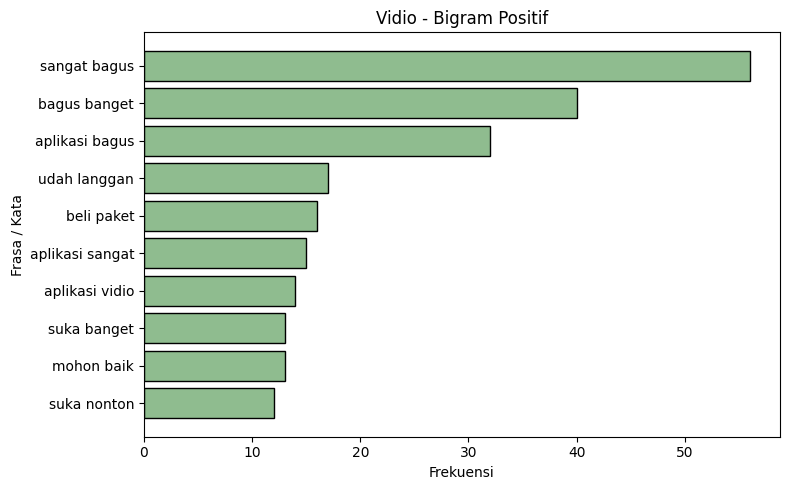

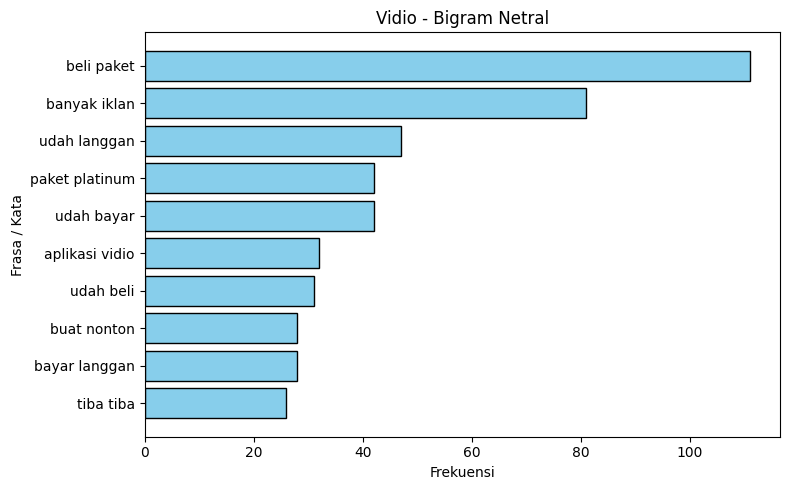

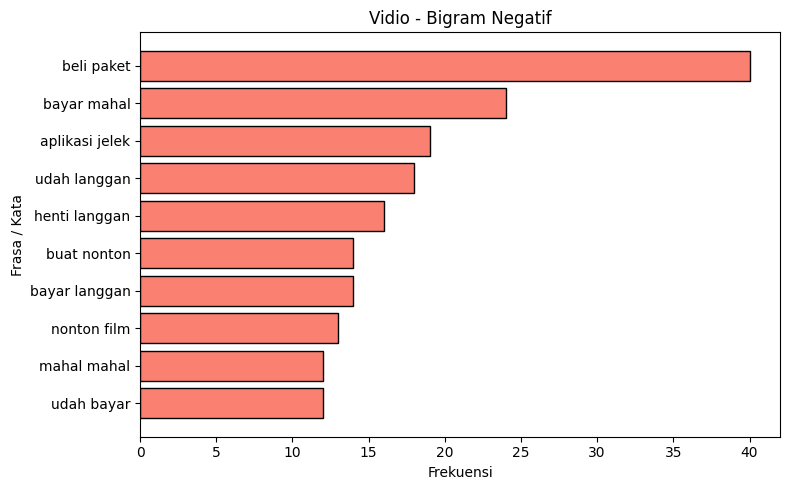

In [48]:
plot_ngram_bar(
    df_vidio[df_vidio['sentimen_lexicon2']=='Positif'],
    'stemming2',
    (2,2),
    'Vidio - Bigram Positif',
    'darkseagreen'
)

plot_ngram_bar(
    df_vidio[df_vidio['sentimen_lexicon2']=='Netral'],
    'stemming2',
    (2,2),
    'Vidio - Bigram Netral',
    'skyblue'
)

plot_ngram_bar(
    df_vidio[df_vidio['sentimen_lexicon2']=='Negatif'],
    'stemming2',
    (2,2),
    'Vidio - Bigram Negatif',
    'salmon'
)


### TRIGRAM MASING-MASING SENTIMEN

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

def generate_trigram_tokens2(text):
    if pd.isna(text):
        return []
    words = text.split()
    return [' '.join(words[i:i+3]) for i in range(len(words)-2)]

df_vidio['trigram_tokens2'] = df_vidio['stemming2'].apply(generate_trigram_tokens2)

df_vidio['trigram_text2'] = df_vidio['trigram_tokens2'].apply(lambda x: ', '.join(x))

df_vidio.to_excel(
    "hasil_trigram_vidio.xlsx",
    index=False
)

print(" File Excel berhasil disimpan: hasil_trigram_vidio.xlsx")

 File Excel berhasil disimpan: hasil_trigram_vidio.xlsx


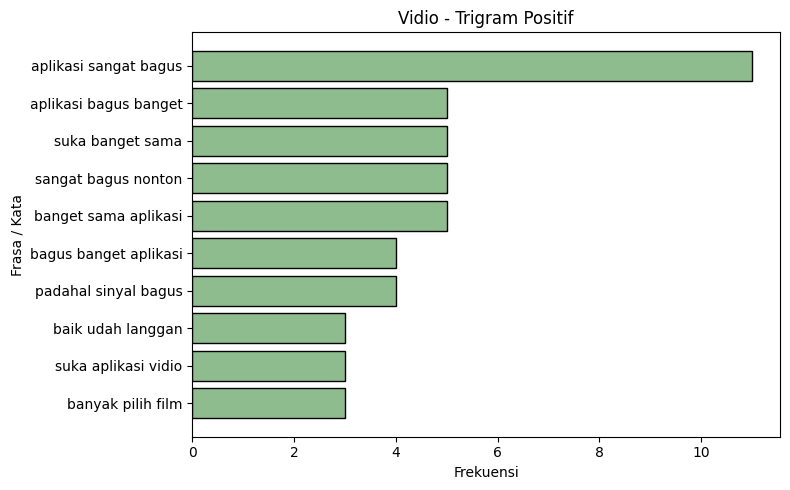

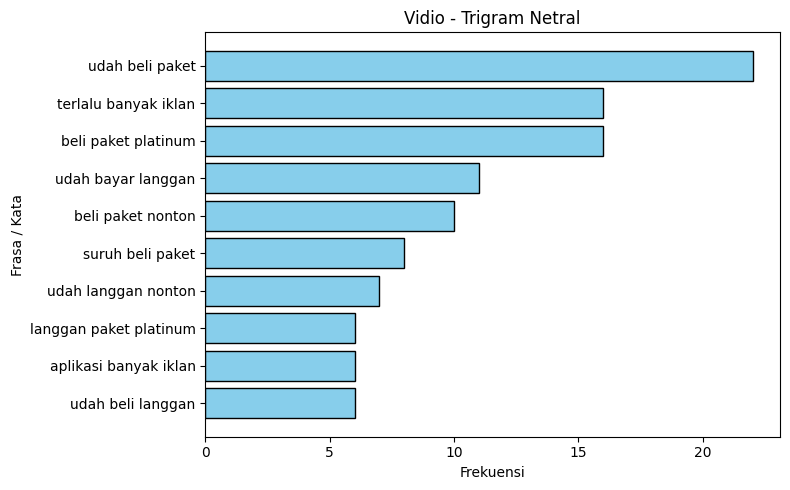

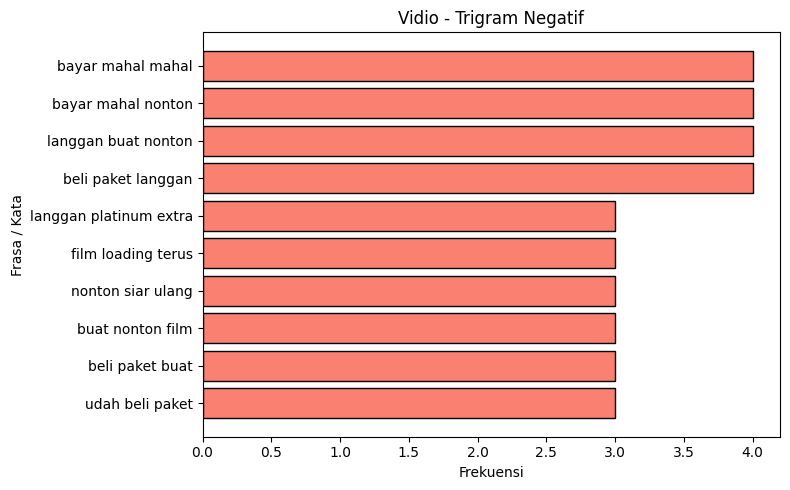

In [52]:
plot_ngram_bar(
    df_vidio[df_vidio['sentimen_lexicon2']=='Positif'],
    'stemming2',
    (3,3),
    'Vidio - Trigram Positif',
    'darkseagreen'
)

plot_ngram_bar(
    df_vidio[df_vidio['sentimen_lexicon2']=='Netral'],
    'stemming2',
    (3,3),
    'Vidio - Trigram Netral',
    'skyblue'
)

plot_ngram_bar(
    df_vidio[df_vidio['sentimen_lexicon2']=='Negatif'],
    'stemming2',
    (3,3),
    'Vidio - Trigram Negatif',
    'salmon'
)

# HASIL VALIDASI LEXICON NETFLIX & VIDIO

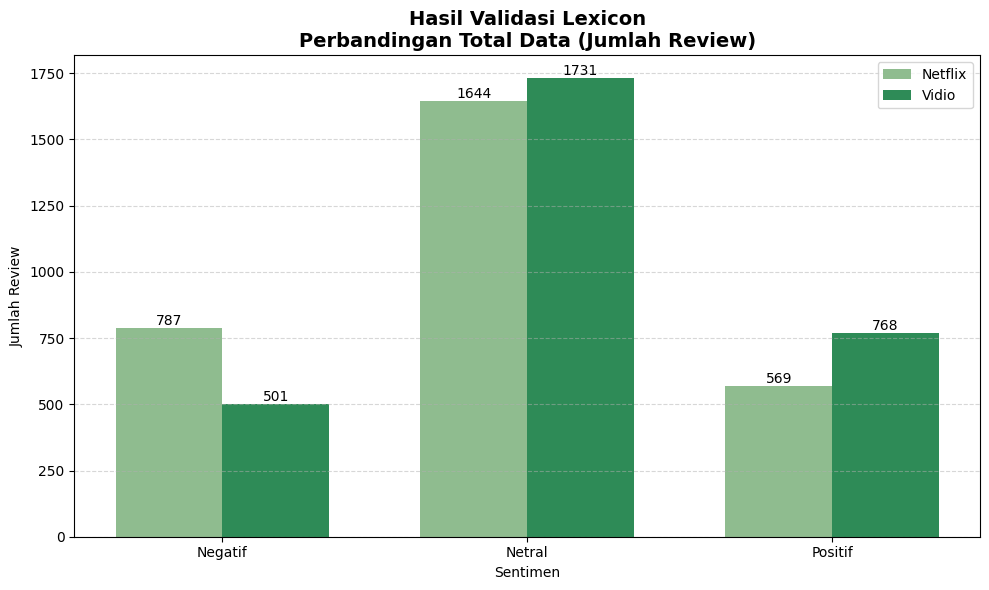

In [53]:
import numpy as np
import matplotlib.pyplot as plt

sentimen = ['Negatif', 'Netral', 'Positif']

netflix_counts = (
    df_netflix['sentimen_lexicon']
    .value_counts()
    .reindex(sentimen, fill_value=0)
)

vidio_counts = (
    df_vidio['sentimen_lexicon2']
    .value_counts()
    .reindex(sentimen, fill_value=0)
)

x = np.arange(len(sentimen))
width = 0.35

plt.figure(figsize=(10, 6))

bars1 = plt.bar(
    x - width/2,
    netflix_counts,
    width,
    label='Netflix',
    color='darkseagreen'
)

bars2 = plt.bar(
    x + width/2,
    vidio_counts,
    width,
    label='Vidio',
    color='seagreen'
)

for bar in bars1:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center',
        va='bottom'
    )

for bar in bars2:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center',
        va='bottom'
    )

plt.title(
    'Hasil Validasi Lexicon\nPerbandingan Total Data (Jumlah Review)',
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.xticks(x, sentimen)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
